In [21]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd

In [69]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [59]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")
#df1 = df1[["IOC_Close","IOC_Open","IOC_High","IOC_Low","IOC_Volume","Price"]]
df1 = df1[["IOC_Close","IOC_Open","IOC_High","IOC_Low","IOC_Volume","Price"]]
df1 = df1.iloc[::-1]

#"Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"

print(df1.head())

values = df1.values




values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())


            IOC_Close   IOC_Open   IOC_High    IOC_Low  IOC_Volume   Price
Date                                                                      
2011-12-12  67.275002  68.000000  68.474998  66.662498   1242948.0  5203.0
2011-12-13  69.212502  67.112503  69.500000  66.349998   3331408.0  5342.0
2011-12-14  67.412498  69.125000  69.500000  67.025002   2859612.0  5209.0
2011-12-15  67.150002  67.750000  68.574997  66.525002   1673504.0  5036.0
2011-12-16  66.737503  67.500000  68.375000  65.675003   1779900.0  4903.0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.106350   0.112121   0.107461   0.113576   0.006584   0.593148  0.117167   
2   0.117167   0.107234   0.113073   0.111815   0.022230   0.617694  0.107118   
3   0.107118   0.118315   0.113073   0.115618   0.018695   0.594208  0.105652   
4   0.105652   0.110744   0.108008   0.112801   0.009810   0.563659  0.103350   
5   0.103350   0.109367   0.106913   0.108013   0.010607   0.540173  0

In [60]:
values = reframed.values
#print(values)
split = int(len(list(df1["IOC_Low"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1326, 1, 6) (1326,) (331, 1, 6) (331,)


Train on 1326 samples, validate on 331 samples
Epoch 1/50
 - 1s - loss: 0.2027 - val_loss: 0.5724
Epoch 2/50
 - 0s - loss: 0.1154 - val_loss: 0.4042
Epoch 3/50
 - 0s - loss: 0.0925 - val_loss: 0.2901
Epoch 4/50
 - 0s - loss: 0.0801 - val_loss: 0.2172
Epoch 5/50
 - 0s - loss: 0.0620 - val_loss: 0.1572
Epoch 6/50
 - 0s - loss: 0.0403 - val_loss: 0.0955
Epoch 7/50
 - 0s - loss: 0.0218 - val_loss: 0.0447
Epoch 8/50
 - 0s - loss: 0.0191 - val_loss: 0.0209
Epoch 9/50
 - 0s - loss: 0.0160 - val_loss: 0.0311
Epoch 10/50
 - 0s - loss: 0.0145 - val_loss: 0.0228
Epoch 11/50
 - 0s - loss: 0.0178 - val_loss: 0.0184
Epoch 12/50
 - 0s - loss: 0.0145 - val_loss: 0.0178
Epoch 13/50
 - 0s - loss: 0.0234 - val_loss: 0.0232
Epoch 14/50
 - 0s - loss: 0.0159 - val_loss: 0.0172
Epoch 15/50
 - 0s - loss: 0.0122 - val_loss: 0.0177
Epoch 16/50
 - 0s - loss: 0.0122 - val_loss: 0.0189
Epoch 17/50
 - 0s - loss: 0.0137 - val_loss: 0.0167
Epoch 18/50
 - 0s - loss: 0.0140 - val_loss: 0.0188
Epoch 19/50
 - 0s - loss: 

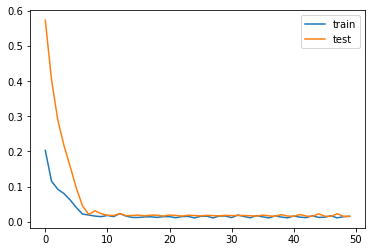

Test RMSE: 3.867


In [61]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


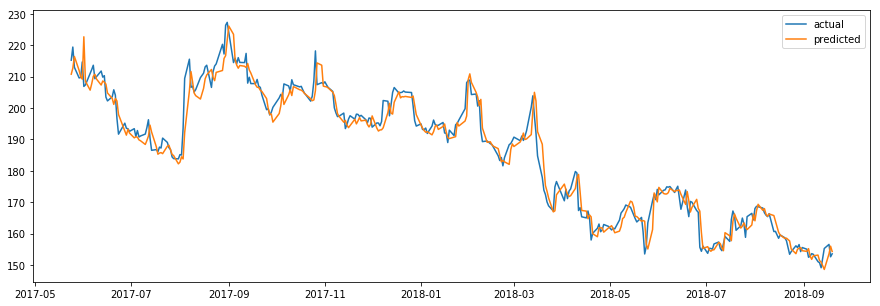

In [66]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [67]:
print(list(inv_y))

[215.275, 219.475, 213.025, 209.625, 209.77498, 214.72502, 206.92499, 207.4, 211.025, 212.3, 213.675, 209.375, 210.025, 211.825, 209.875, 210.35, 203.52501, 202.3, 203.59999, 205.85, 204.12498, 196.75002, 191.7, 195.19998, 193.575, 193.42502, 192.6, 193.45, 190.925, 192.85, 190.8, 191.125, 191.725, 193.75002, 196.3, 190.475, 186.55, 186.775, 186.075, 187.575, 187.27498, 190.45, 189.075, 187.4, 186.82501, 184.45, 183.90001, 183.82498, 185.17502, 185.05, 193.525, 209.475, 215.6, 206.625, 207.025, 205.15, 205.9, 209.72499, 211.15, 213.15, 213.675, 206.60002, 211.6, 213.425, 214.1, 220.35, 217.25, 226.42502, 227.35, 224.14998, 214.525, 215.925, 214.125, 216.1, 214.57501, 214.525, 217.45, 207.975, 209.84999, 207.825, 207.825, 209.15, 206.975, 206.625, 204.20001, 199.5, 199.825, 197.825, 198.7, 200.25, 203.275, 204.375, 203.375, 207.72499, 207.075, 205.425, 209.04999, 207.44998, 207.3, 206.77498, 206.95, 205.80002, 204.825, 202.225, 203.85, 208.625, 218.25, 207.475, 208.12502, 207.75, 208.4,

In [68]:
print(list(inv_yhat))

[210.82034, 212.72867, 216.47029, 212.02567, 209.99411, 209.25264, 222.7485, 208.56354, 205.73843, 207.79066, 210.13782, 210.78899, 209.287, 207.36754, 208.6573, 208.28029, 207.66628, 204.83453, 203.11118, 201.19653, 203.07755, 202.29604, 197.97789, 192.72438, 191.38899, 193.2402, 192.04651, 190.52287, 190.86902, 190.73265, 189.87277, 189.586, 188.41972, 189.66255, 191.08672, 194.57265, 192.37906, 187.68202, 185.30597, 185.65358, 185.83177, 185.48497, 187.83994, 188.17625, 186.66327, 185.25735, 184.86891, 182.23604, 182.77397, 184.48254, 183.79669, 192.2205, 205.49588, 211.66565, 208.46597, 204.83163, 203.98195, 202.9015, 206.30344, 209.34674, 210.57469, 212.32214, 209.83026, 208.76321, 211.3992, 211.99751, 215.83742, 216.75352, 221.68779, 226.17441, 223.53879, 215.52527, 213.75339, 212.72713, 213.5887, 213.35641, 212.93681, 214.22218, 212.1798, 211.18471, 207.39998, 206.66837, 206.57655, 205.71074, 205.32068, 203.0383, 199.95483, 197.98904, 198.12973, 195.53807, 198.27351, 200.7201, 2

In [ ]:
#ONLY OHLC

            IOC_Close   IOC_Open   IOC_High    IOC_Low  IOC_Volume
Date                                                              
2011-12-12  67.275002  68.000000  68.474998  66.662498   1242948.0
2011-12-13  69.212502  67.112503  69.500000  66.349998   3331408.0
2011-12-14  67.412498  69.125000  69.500000  67.025002   2859612.0
2011-12-15  67.150002  67.750000  68.574997  66.525002   1673504.0
2011-12-16  66.737503  67.500000  68.375000  65.675003   1779900.0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.106350   0.112121   0.107461   0.113576   0.006584  0.117167  0.107234   
2   0.117167   0.107234   0.113073   0.111815   0.022230  0.107118  0.118315   
3   0.107118   0.118315   0.113073   0.115618   0.018695  0.105652  0.110744   
4   0.105652   0.110744   0.108008   0.112801   0.009810  0.103350  0.109367   
5   0.103350   0.109367   0.106913   0.108013   0.010607  0.101256  0.103517   

    var3(t)   var4(t)   var5(t)  
1  0.113073  0.1

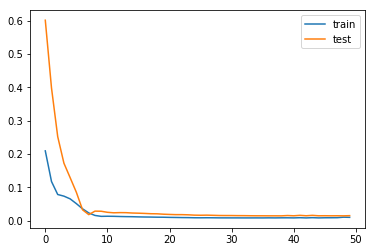

Test RMSE: 3.755


In [71]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")
#df1 = df1[["IOC_Close","IOC_Open","IOC_High","IOC_Low","IOC_Volume","Price"]]
df1 = df1[["IOC_Close","IOC_Open","IOC_High","IOC_Low","IOC_Volume"]]
df1 = df1.iloc[::-1]

#"Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"

print(df1.head())

values = df1.values




values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())


values = reframed.values
#print(values)
split = int(len(list(df1["IOC_Low"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


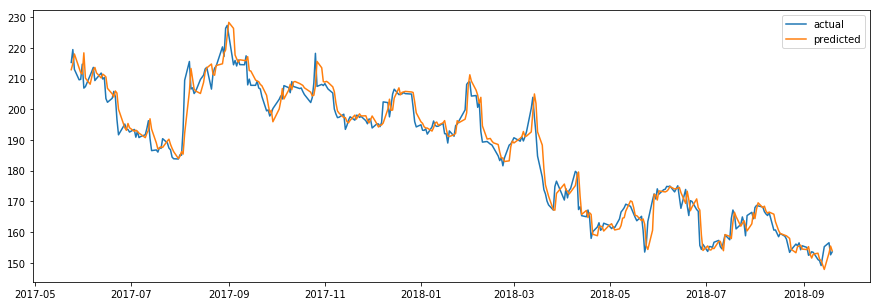

In [72]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [73]:
print(list(inv_y))

[215.275, 219.475, 213.025, 209.625, 209.77498, 214.72502, 206.92499, 207.4, 211.025, 212.3, 213.675, 209.375, 210.025, 211.825, 209.875, 210.35, 203.52501, 202.3, 203.59999, 205.85, 204.12498, 196.75002, 191.7, 195.19998, 193.575, 193.42502, 192.6, 193.45, 190.925, 192.85, 190.8, 191.125, 191.725, 193.75002, 196.3, 190.475, 186.55, 186.775, 186.075, 187.575, 187.27498, 190.45, 189.075, 187.4, 186.82501, 184.45, 183.90001, 183.82498, 185.17502, 185.05, 193.525, 209.475, 215.6, 206.625, 207.025, 205.15, 205.9, 209.72499, 211.15, 213.15, 213.675, 206.60002, 211.6, 213.425, 214.1, 220.35, 217.25, 226.42502, 227.35, 224.14998, 214.525, 215.925, 214.125, 216.1, 214.57501, 214.525, 217.45, 207.975, 209.84999, 207.825, 207.825, 209.15, 206.975, 206.625, 204.20001, 199.5, 199.825, 197.825, 198.7, 200.25, 203.275, 204.375, 203.375, 207.72499, 207.075, 205.425, 209.04999, 207.44998, 207.3, 206.77498, 206.95, 205.80002, 204.825, 202.225, 203.85, 208.625, 218.25, 207.475, 208.12502, 207.75, 208.4,

In [74]:
print(list(inv_yhat))

[212.91968, 214.89368, 218.04117, 213.54306, 211.95192, 211.48943, 218.40971, 210.18047, 208.19453, 210.4892, 212.7514, 213.64389, 211.88907, 210.2288, 211.46243, 211.07788, 210.56606, 206.83864, 205.04387, 204.0197, 205.98372, 205.30664, 200.03343, 193.99936, 193.15857, 195.38466, 194.00728, 192.85835, 193.22182, 192.79478, 192.23251, 191.90073, 190.7675, 192.1781, 193.21997, 196.92575, 193.55812, 189.06126, 187.06163, 187.33328, 187.81027, 187.5809, 189.68582, 190.27629, 188.59418, 187.3174, 186.22438, 183.96443, 184.6905, 186.22694, 185.42102, 192.2429, 205.82773, 213.31729, 209.99245, 206.6591, 205.97522, 205.16924, 208.76833, 212.14507, 213.47452, 214.77513, 211.44495, 211.10922, 214.28227, 214.84831, 218.41583, 219.35336, 224.08582, 228.34421, 226.38628, 217.69618, 216.47029, 215.36418, 216.14569, 215.9357, 215.84534, 217.15953, 212.63896, 212.48035, 209.56781, 209.21571, 209.01483, 208.13373, 207.68562, 204.57257, 201.60628, 198.91022, 199.71005, 195.95818, 200.10715, 202.7452, 